# **Predictive Modeling for Running Duration**

A detailed exploratory data analysis has been conducted in a separate notebook. Please refer to it [here]("https://github.com/Redback-Operations/redback-fit-sports-performance/blob/main/Running%20Analysis/EDA_Running_merged.ipynb").

The purpose of this notebook is to evaluate and compare the performance of linear regression and Random Forest models in predicting a runner's total running time using minimal input features. To enrich the dataset and reduce the number of required inputs, pace calculations have been included.


In [117]:
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# URL of the CSV file
url = 'https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Cycling%20Analysis/data/extended_activities_TRI001.csv'

# Read the CSV file directly from the URL
df = pd.read_csv(url)

# Isolate the running data component
df_run = df[df['Activity Type'] == 'Run']

df_run.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Elapsed Time,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,...,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
305,7057073739,"28 Apr 2022, 21:49:44",Morning Run,Run,4127,178.0,78.0,False,NaN,activities/7511868053.csv.gz,...,296.8,271.9,259.4,247.5,242.9,241.5,239.5,235.6,0.0,0.0
306,7067754767,"1 May 2022, 00:11:03",Morning Run,Run,7723,173.0,185.0,False,NaN,activities/7523482307.csv.gz,...,376.5,343.7,326.4,316.3,315.0,297.3,291.1,280.1,275.8,272.1
307,7073448977,"1 May 2022, 23:04:26",Morning Run,Run,4202,182.0,255.0,False,NaN,activities/7529709708.csv.gz,...,342.0,300.0,282.7,267.1,262.4,261.1,258.3,253.2,0.0,0.0
308,7083686840,"3 May 2022, 20:34:15",Morning Run,Run,4086,188.0,276.0,False,NaN,activities/7540825061.csv.gz,...,326.0,302.3,287.4,275.5,270.9,269.0,267.2,263.4,0.0,0.0
309,7094718079,"5 May 2022, 21:44:27",Morning Run,Run,4290,184.0,241.0,False,NaN,activities/7552770129.csv.gz,...,320.9,315.3,306.2,271.2,269.9,263.9,264.2,258.8,0.0,0.0


## **Feature Engineering**

The following attributes have been calculated and added to the dataset:

`Pace`: The average speed over a given distance, expressed in minutes per kilometer. It shows how many minutes it takes to complete one kilometer.

`Rolling Avg Pace 90D`: The rolling (or moving) average of the pace over the last 90 days, calculated across all available data points in that window.

In [153]:
# 'Elapsed Time' is in seconds, converting it to minutes and dividing by the distance in kilometers
df_run['Pace'] = (df_run['Elapsed Time'] / 60) / df_run['Distance']

df_run['Rolling Avg Pace 90D'] = df_run['Pace'].rolling(window=90, min_periods=1).mean()

## **Predictive Modelling**

In [174]:
# Final dataframe to be used for modelling
df_run_clean = df_run[['Distance', 'Rolling Avg Pace 90D', 'Moving Time']]
df_run_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 305 to 560
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Distance              164 non-null    float64
 1   Rolling Avg Pace 90D  164 non-null    float64
 2   Moving Time           164 non-null    float64
dtypes: float64(3)
memory usage: 5.1 KB


In [175]:
# Split feature and target attributes
X = df_run[['Distance', 'Rolling Avg Pace 90D']]
y = df_run['Moving Time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialise a scaler: either StandardScaler or MinMaxScaler
scaler = StandardScaler()  # For standardization

# Fit the scaler on the training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Linear Regression Model**

Ridge regression was used to enhance the predictive accuracy and robustness of our linear regression model. Unlike traditional linear regression, Ridge incorporates a regularisation term that penalises overly complex models by shrinking the coefficients of less important features towards zero. This prevents the model from overfitting, especially when dealing with multicollinearity or high-dimensional data where standard linear regression might struggle. The `alpha` parameter controls the strength of this regularisation, and tuning it via grid search ensures that we find an optimal value to maintain model interpretability while maximizing predictive power.

In [188]:
# Define the Ridge model
lr_model = Ridge()

# Define a parameter grid to tune 'alpha'
lr_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialise GridSearchCV to find the best alpha
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the training data
lr_grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model and its parameters
best_ridge_model = lr_grid_search.best_estimator_
best_params = lr_grid_search.best_params_

# Predict on the testing set using the best model
lr_y_pred = best_ridge_model.predict(X_test_scaled)

# Calculate evaluation metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

# Return the key metrics
print(f"Best Ridge Alpha: {best_params['alpha']}")
print(f"Ridge Regression RMSE: {round(lr_rmse, 4)}")
print(f"Ridge Regression R2: {round(lr_r2, 4)}")

Best Ridge Alpha: 0.01
Ridge Regression RMSE: 129.8546
Ridge Regression R2: 0.9948


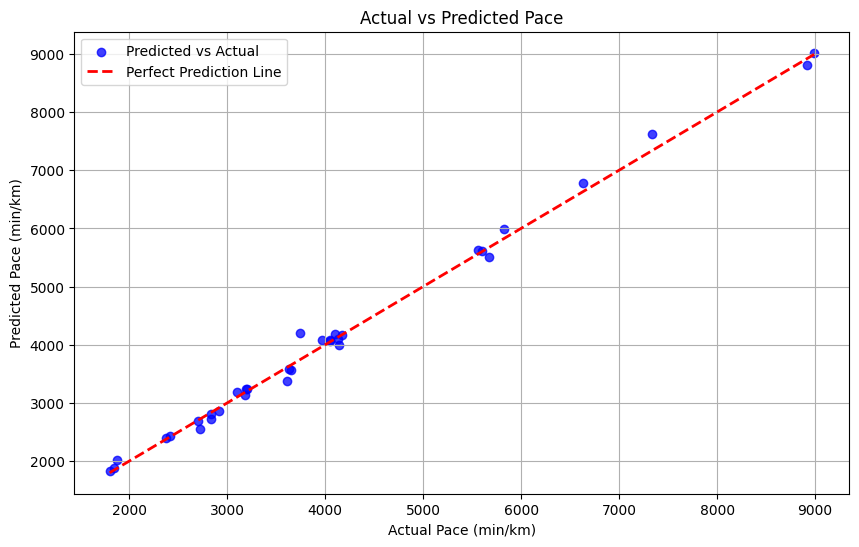

In [182]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred, alpha=0.75, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.title('Actual vs Predicted Pace')
plt.legend()
plt.grid(True)
plt.show()


**Ridge Regression Model Results**

The Ridge regression model determined that an alpha value of 0.01 provided the best regularisation strength. This value was selected as it balanced the model's fit by preventing overfitting while still capturing the data patterns. With this optimal alpha, the Ridge model achieved a Root Mean Squared Error (RMSE) of 129.8546, meaning that the model's predictions typically deviate from the actual values by around 130 seconds. Furthermore, an R² score of 0.9948 indicates that the model can explain over 99% of the variance in the target variable, demonstrating its high predictive accuracy and ability to generalise well to unseen data. The strong performance of this linear regression model shows that the relationship between the features and the target variable is not overly complex and that a linear approach can effectively model it. The Ridge regression model thus provides a good result and reliable performance.

### **Random Forest Model**
The Random Forest model was chosen to capitalise on the strengths of ensemble learning, providing predictive performance by combining multiple decision trees. Each tree is built using a random subset of features and samples, which introduces diversity and reduces the risk of overfitting compared to a single decision tree. The aggregation of these trees ensures the model generalises well to unseen data by averaging or voting across the predictions.

 The hyperparameters, such as n_estimators, max_depth, min_samples_split, and min_samples_leaf, were optimised using grid search to find the best combination for our dataset. Tuning these parameters allows us to carefully control the model's complexity and fit, ensuring that each tree is sufficiently deep while still maintaining computational efficiency.

In [187]:
# Initialise the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Define a parameter grid to tune
rf_param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialise GridSearchCV to find the best combination
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

# Retrieve the best model and its parameters
best_rf_model = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_

# Make predictions on the testing set using the best model
rf_y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

# Return the key metrics
print(f"Best RF Parameters: {best_params}")
print(f"Random Forest RMSE: {round(rf_rmse, 4)}")
print(f"Random Forest R2: {round(rf_r2, 4)}")


Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest RMSE: 123.7465
Random Forest R2: 0.9953


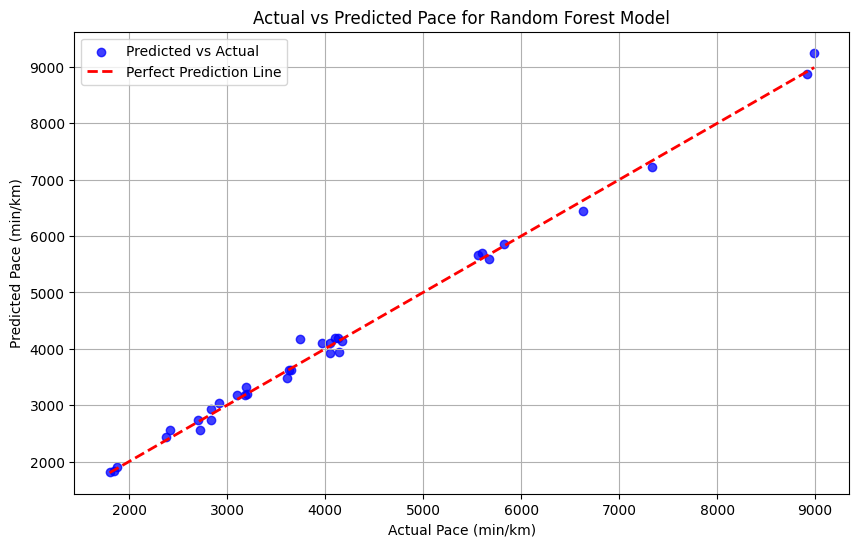

In [177]:
# Create a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred, alpha=0.75, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.title('Actual vs Predicted Pace for Random Forest Model')
plt.legend()
plt.grid(True)
plt.show()

**Random Forest Model Results**

The Random Forest model found that the best parameters for this dataset were a maximum depth of 10, a minimum of 2 samples per leaf, a minimum of 2 samples per split, and 100 estimators. These parameters ensure that the model balances between depth (capturing complex patterns) and generalisation (avoiding overfitting). The model achieved a Root Mean Squared Error (RMSE) of 123.7465, meaning that predictions typically deviate from the actual values by about 124 seconds. With an R² score of 0.9953, the model explains over 99.5% of the variance in the target variable, indicating excellent predictive accuracy. The strong performance of the Random Forest model illustrates its ability to capture intricate relationships between features and the target variable, while maintaining robustness through ensemble learning. The combination of these optimal parameters allows the model to provide reliable predictions and efficient performance.

## **Model Outcomes**
In comparing the results from both the Ridge regression and Random Forest models, we find that each model performs exceptionally well, achieving high predictive accuracy with R² scores above 0.99. However, there are subtle differences in their predictive power and suitability for this specific dataset.

- **Ridge Regression**: This model, with an optimised alpha of 0.01, achieved an RMSE of 129.8546 and an R² score of 0.9948. Its strong performance demonstrates that the relationship between features and the target is not highly complex. The linear nature of Ridge regression ensures that the model is efficient, straightforward to interpret, and generalises well with minimal overfitting.

- **Random Forest**: With optimised parameters such as a max depth of 10, a minimum of 2 samples per split, 2 samples per leaf, and 100 trees, the Random Forest model achieved a slightly lower RMSE of 123.7465 and a higher R² score of 0.9953. This indicates that it better captures intricate patterns in the data. Random Forest is robust to overfitting due to its ensemble nature and can handle non-linear relationships between features.

### Conclusion
- **Best Model**: The Random Forest model appears to be the better option based on its slightly lower RMSE and higher R² score. Its ensemble approach helps capture complex relationships more effectively than the linear Ridge model.
- **Recommendation**: If interpretability and computational efficiency are crucial, the Ridge model remains a solid choice, providing valuable insight into feature importance. However, for maximum predictive accuracy, the Random Forest model is the best option, offering reliable performance by leveraging its ensemble learning strategy.
